In [ ]:
# torch
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms

from PIL import Image

from sklearn.model_selection import train_test_split

In [3]:
import torch
from glob import glob
import os
import random

# Global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "/kaggle/input/stroke-dataset-1/Brain_Data_Organised"  # Update the dataset path to point to the single folder
image_size = (224, 224)
num_classes = 2

# Get all image paths from both folders (normal and stroke)
normal_image_paths = glob(os.path.join(dataset_path, "Normal", "*.jpg"))
stroke_image_paths = glob(os.path.join(dataset_path, "Stroke", "*.jpg"))

# Combine the paths and shuffle them
image_paths = normal_image_paths + stroke_image_paths
random.shuffle(image_paths)

# Split the image paths into train and test sets
train_ratio = 0.8  # 80% for training, 20% for testing
train_size = int(train_ratio * len(image_paths))
train_paths = image_paths[:train_size]
test_paths = image_paths[train_size:]

# Check device
print(device)

# Print the number of images in each set for verification
print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_paths)}")
print(f"Testing set size: {len(test_paths)}")


cuda
Total images: 2501
Training set size: 2000
Testing set size: 501


In [4]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [6]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

Epoch 1: Train Loss: 0.7627, Train Acc: 64.55%, Val Loss: 0.7320, Val Acc: 70.40%
Epoch 2: Train Loss: 0.5071, Train Acc: 76.25%, Val Loss: 0.3925, Val Acc: 78.80%
Epoch 3: Train Loss: 0.3726, Train Acc: 82.75%, Val Loss: 0.4179, Val Acc: 83.20%
Epoch 4: Train Loss: 0.3004, Train Acc: 87.20%, Val Loss: 0.3477, Val Acc: 83.60%
Epoch 5: Train Loss: 0.2587, Train Acc: 89.85%, Val Loss: 0.2289, Val Acc: 88.80%
Epoch 6: Train Loss: 0.2128, Train Acc: 91.30%, Val Loss: 0.2799, Val Acc: 89.60%
Epoch 7: Train Loss: 0.1453, Train Acc: 94.25%, Val Loss: 0.2599, Val Acc: 90.40%
Epoch 8: Train Loss: 0.1695, Train Acc: 93.55%, Val Loss: 0.2343, Val Acc: 92.80%
Epoch 9: Train Loss: 0.1631, Train Acc: 94.00%, Val Loss: 0.1729, Val Acc: 94.00%
Epoch 10: Train Loss: 0.1063, Train Acc: 96.40%, Val Loss: 0.1708, Val Acc: 95.20%


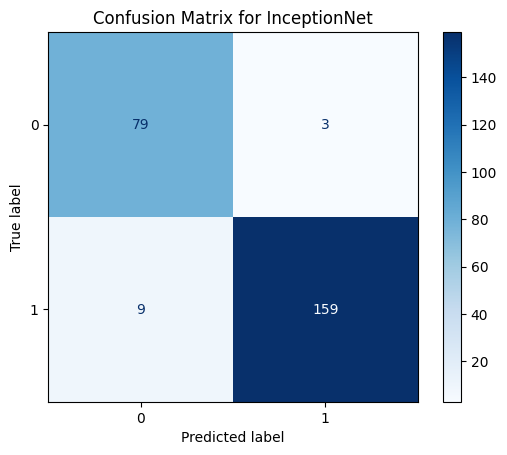

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        82
           1       0.98      0.95      0.96       168

    accuracy                           0.95       250
   macro avg       0.94      0.95      0.95       250
weighted avg       0.95      0.95      0.95       250



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import timm  # Make sure it's installed: pip install timm

# Assuming these are predefined
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2  # Update if needed

# ========================== InceptionNet Model ==========================
class InceptionNetModel(nn.Module):
    def __init__(self, num_classes):
        super(InceptionNetModel, self).__init__()
        self.model = timm.create_model('inception_v3', pretrained=True, num_classes=num_classes)
        # timm's inception_v3 expects input size 299x299
        self.model.aux_logits = False  # Optional, to disable auxiliary logits if not used

    def forward(self, x):
        return self.model(x)

# ========================== Initialize Model, Loss, Optimizer ==========================
model = InceptionNetModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ========================== Training Function ==========================
def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# ========================== Evaluation Function ==========================
def eval_model(loader):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(data)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

# ========================== Main Training Loop ==========================
best_score = float("inf")
n_epochs = 10
tolerance = 0

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch()
    val_loss, val_acc = eval_model(val_loader)

    if val_loss < best_score:
        best_score = val_loss
        torch.save(model.state_dict(), "inception_best.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            print("Early stopping triggered.")
            break

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")

# ========================== Final Evaluation ==========================
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ========================== Metrics and Confusion Matrix ==========================
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for InceptionNet")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds))
